In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import subprocess
import os
import pandas as pd

/home/qukun/ccp1997/miniconda3/envs/scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
'read h5ad'
gbm = sc.read_h5ad('/home/qukun/ccp1997/GBM_10X/ng_revised/harmony/gbm_integrated_final.h5ad')
gbm = gbm.raw.to_adata()
gbm = remove_sparsity(gbm)
gbm.var.index = gbm.var['_index']

In [8]:
'reference no neurons'
gbm = gbm[gbm.obs['Technology'] != 'snRNA']
hvgs = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/harmony/var_features.csv',index_col=0).index.tolist()[:3000]

'load quary'
patch = sc.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/tpm_merge_log.csv')
patch = patch.T

tpm_log = pd.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/tpm_merge_log.csv',index_col=0)
patch.obs.index = tpm_log.columns
patch = patch[:, np.intersect1d(patch.var.index.tolist(), hvgs)]

'remove sparsity'
patch = remove_sparsity(patch)

gbm = gbm[:, np.intersect1d(patch.var.index.tolist(), hvgs)]

In [9]:
len(np.intersect1d(patch.var.index.tolist(), hvgs))

2913

In [332]:
'Training the model'

gbm = gbm.copy()
sca.models.SCVI.setup_anndata(gbm, batch_key='orig.ident', labels_key='annotation')

vae = sca.models.SCVI(
    gbm,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

vae.train()
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")
scanvae.train(max_epochs=20)

In [333]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = gbm.obs['annotation'].tolist()
reference_latent.obs["batch"] = gbm.obs['orig.ident'].tolist()

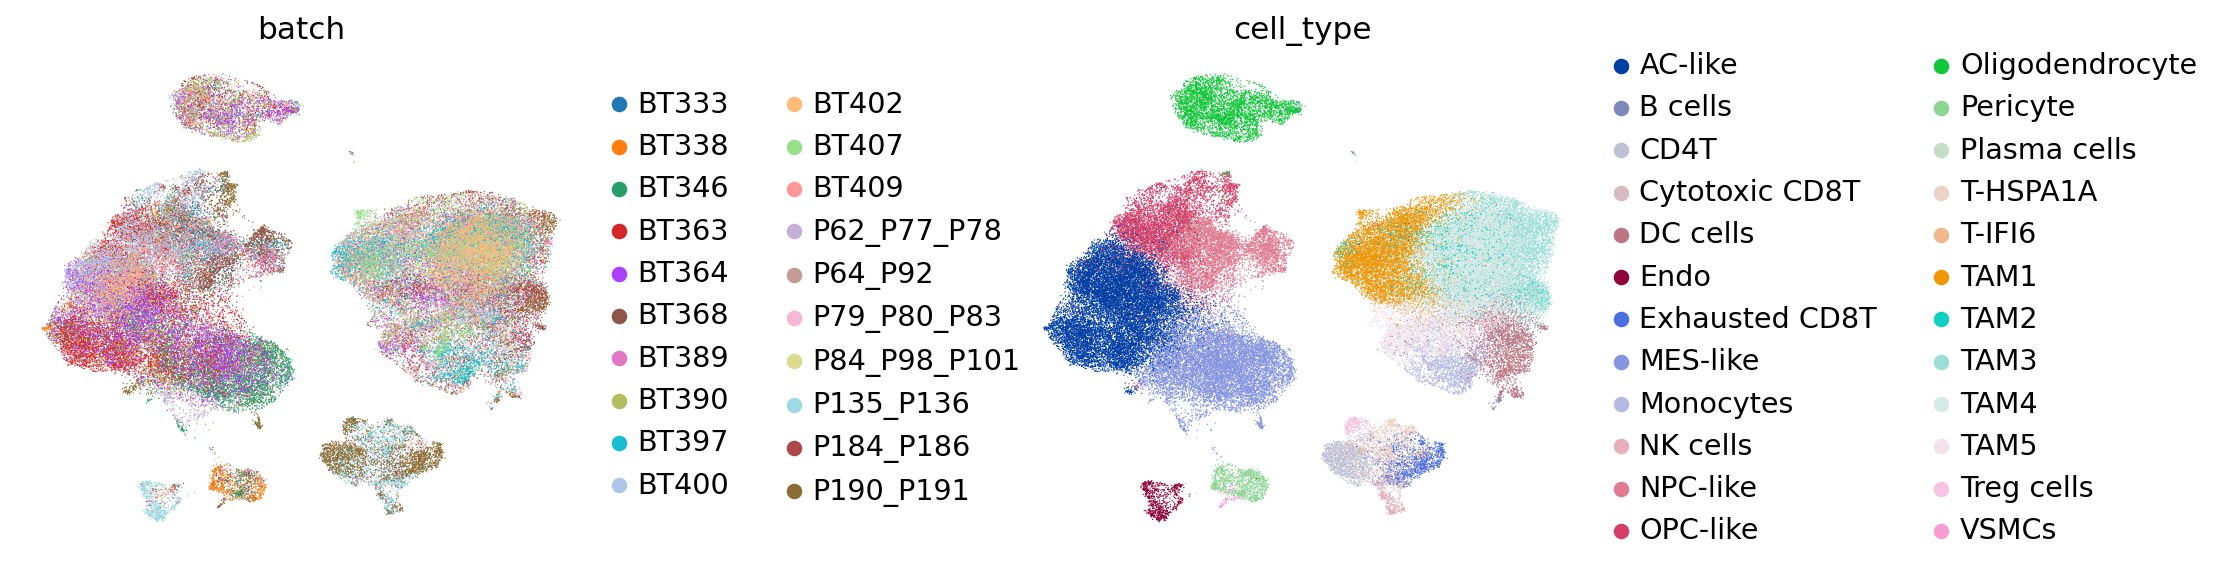

In [354]:
sc.pp.neighbors(reference_latent, n_neighbors=10)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [355]:
'Accuracy on the training set'
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.8444156257264153


In [350]:
'save model'
ref_path = '/home/qukun/ccp1997/GBM_10X/ng_revised/scarches_hvg3000_remove_neurons/'
scanvae.save(ref_path, overwrite=True)
reference_latent.write('/home/qukun/ccp1997/GBM_10X/ng_revised/scarches_hvg3000_remove_neurons/reference_latent.h5ad')

In [16]:
'load reference'
reference_latent = sc.read_h5ad('/home/qukun/ccp1997/GBM_10X/ng_revised/scarches_hvg3000_remove_neurons/reference_latent.h5ad')

'generate tumor umap'
reference_latent.obs.index = gbm.obs.index.tolist()

tumor_cells = reference_latent.obs.loc[reference_latent.obs['cell_type'] == 'MES-like'].index.tolist() + \
reference_latent.obs.loc[reference_latent.obs['cell_type'] == 'AC-like'].index.tolist() + \
reference_latent.obs.loc[reference_latent.obs['cell_type'] == 'OPC-like'].index.tolist() + \
reference_latent.obs.loc[reference_latent.obs['cell_type'] == 'NPC-like'].index.tolist()

tumor = reference_latent[tumor_cells]

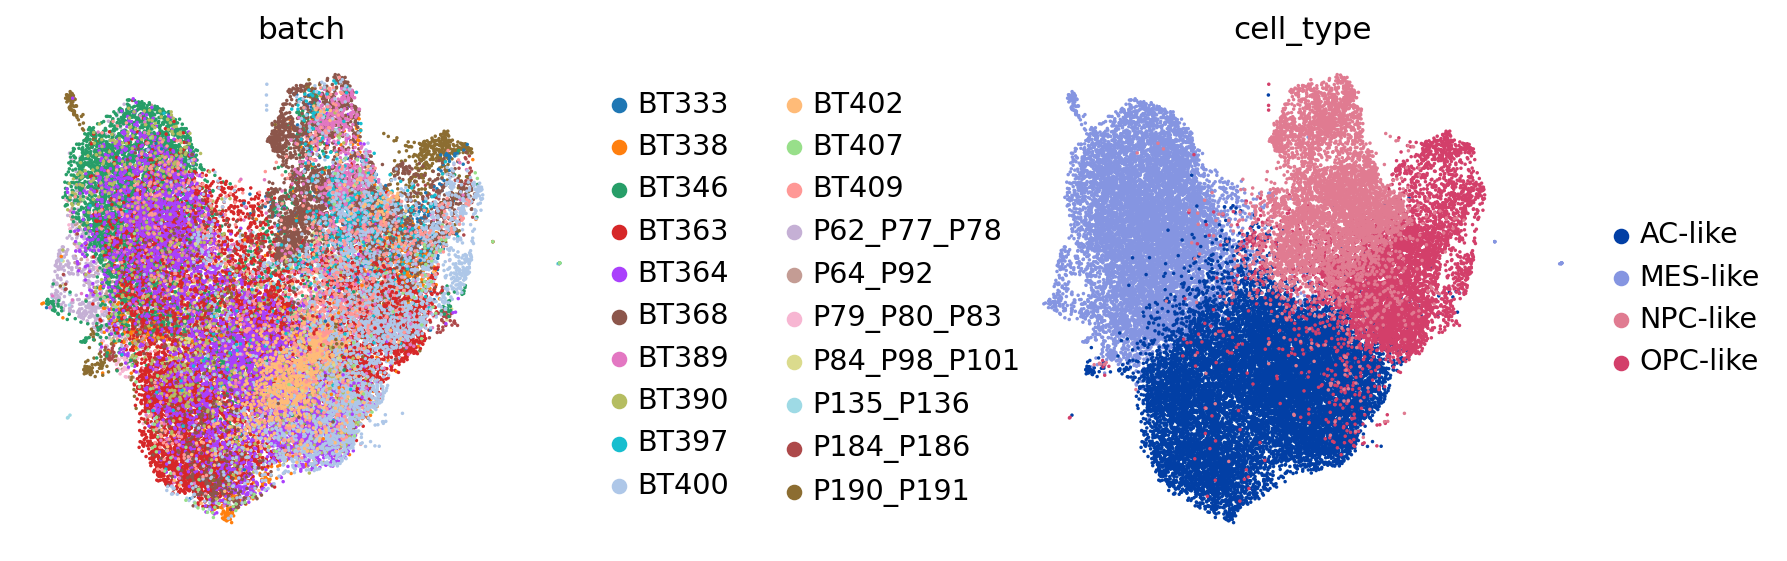

In [ ]:
sc.tl.umap(tumor)
sc.pl.umap(tumor,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           size=10
           )

In [20]:
'save'
umap = pd.DataFrame(tumor.obsm['X_umap'],columns=['UMAP_1','UMAP_2'],index=tumor.obs.index)
umap.to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/scarches_hvg3000_remove_neurons/UMAP.csv')

In [1]:
'predict'

'predict'

In [25]:
patch.obs['orig.ident'] = ['patch-seq'] * patch.shape[0]
filter_cells = tpm_log.columns[(np.sum(tpm_log != 0) >= 500).tolist()]
patch = patch[filter_cells]
patch_prediction = patch.copy()

model = sca.models.SCANVI.load_query_data(
    patch_prediction,
    '/home/qukun/ccp1997/GBM_10X/ng_revised/scarches_hvg3000_remove_neurons/',
    freeze_dropout = True 
)

model._unlabeled_indices = np.arange(patch_prediction.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

In [26]:
model.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [00:08<00:00, 26.06it/s, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=2.5e+3] 

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:08<00:00, 12.26it/s, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=2.5e+3]


In [29]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = patch_prediction.obs['annotation'].tolist()
query_latent.obs['batch'] = patch_prediction.obs['orig.ident'].tolist()

sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)

query_latent.obs['predictions'] = model.predict()

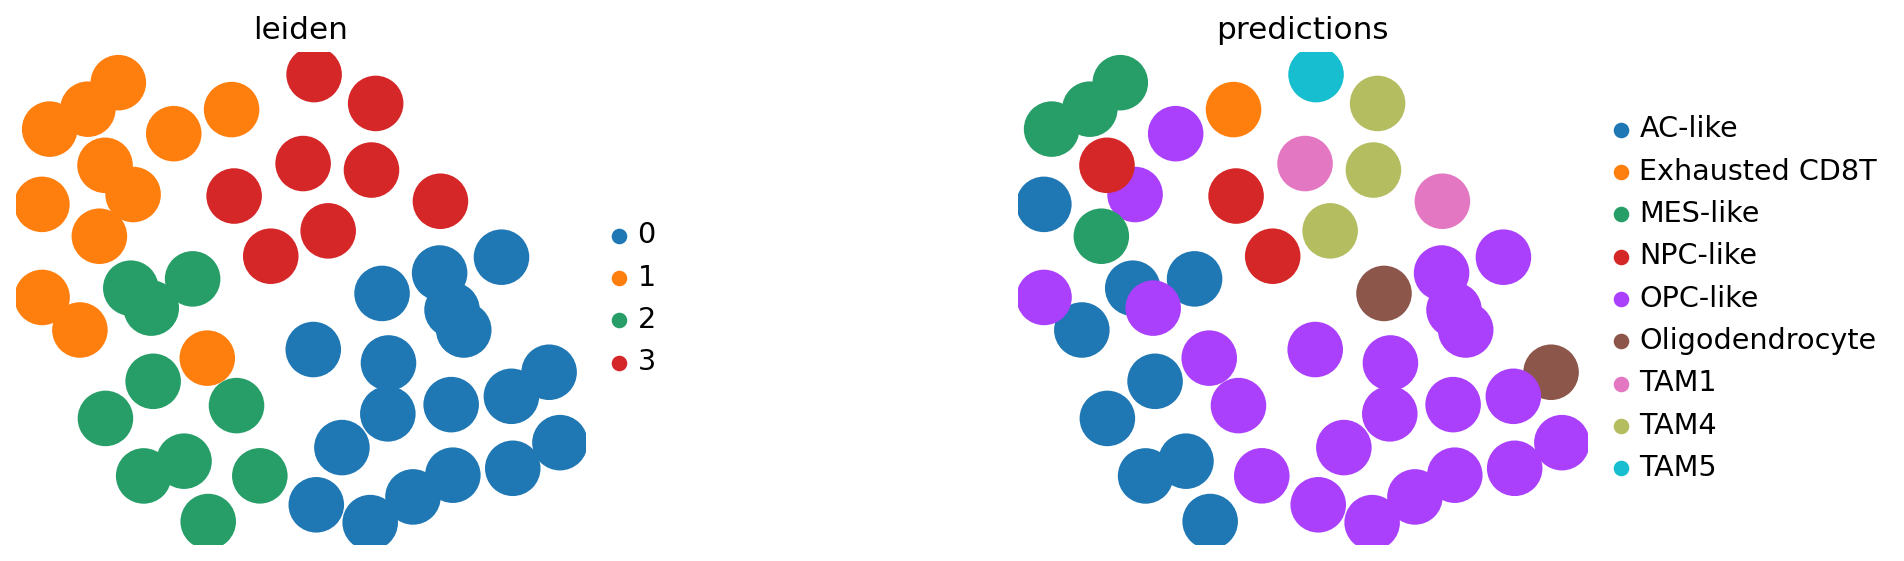

In [30]:
sc.pl.umap(
    query_latent,
    color=["leiden", "predictions"],
    frameon=False,
    wspace=0.6,
)

In [31]:
query_latent.obs.index = patch_prediction.obs.index

In [34]:
'coembedding'
EPSC_cells = ['O12301','021804','021805','021806','021808','030301','030704','030705',
             '030706','030709','031001','031003','031004','031007','031008','031101',
             '032101','032102','032103',
             '033003','033004','033102','033104','033105','033106','033107','033110']
patch_latent = query_latent[np.intersect1d(np.intersect1d(query_latent.obs.index,EPSC_cells),tpm_log.columns[(np.sum(tpm_log != 0) >= 1000).tolist()])]

In [38]:
'merge_adata'
adata_full = gbm.concatenate( patch_prediction[patch_latent.obs.index.tolist()] )

full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))

full_latent.obs['cell_type'] = adata_full.obs['annotation'].tolist()
full_latent.obs['batch'] = adata_full.obs['orig.ident'].tolist()

<Figure size 320x320 with 0 Axes>

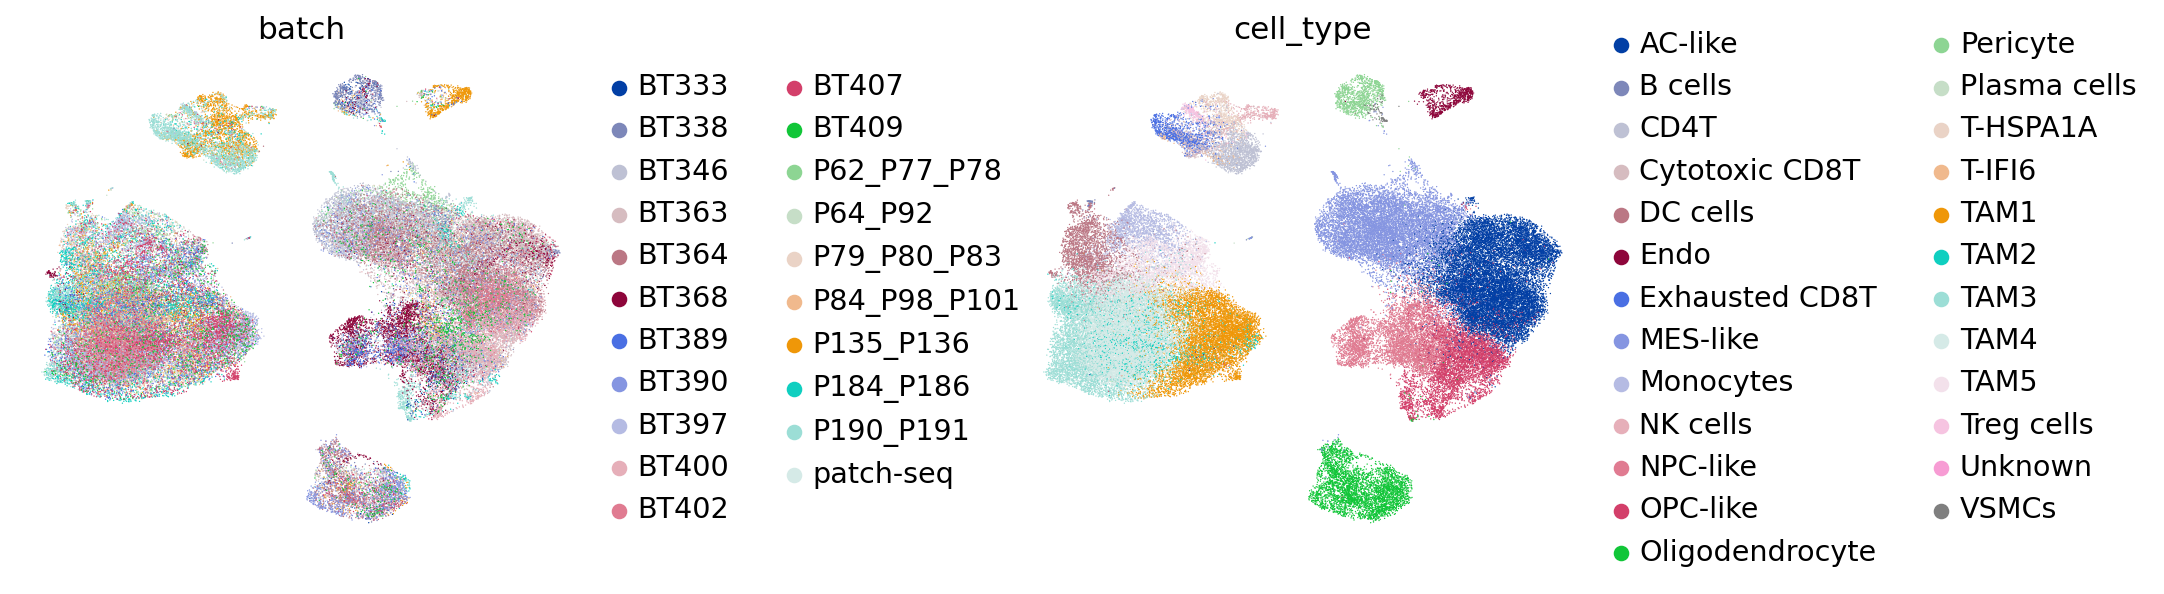

In [39]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [ ]:
'Tumor cells co-embedding'

In [42]:
full_latent.obs.index = gbm.obs.index.tolist() +  patch_latent.obs.index.tolist()

select_cells = full_latent.obs.loc[full_latent.obs['cell_type'] == 'MES-like'].index.tolist() + \
full_latent.obs.loc[full_latent.obs['cell_type'] == 'AC-like'].index.tolist() + \
full_latent.obs.loc[full_latent.obs['cell_type'] == 'OPC-like'].index.tolist() + \
full_latent.obs.loc[full_latent.obs['cell_type'] == 'NPC-like'].index.tolist() + patch_latent.obs.index.tolist()

selected = full_latent[select_cells]

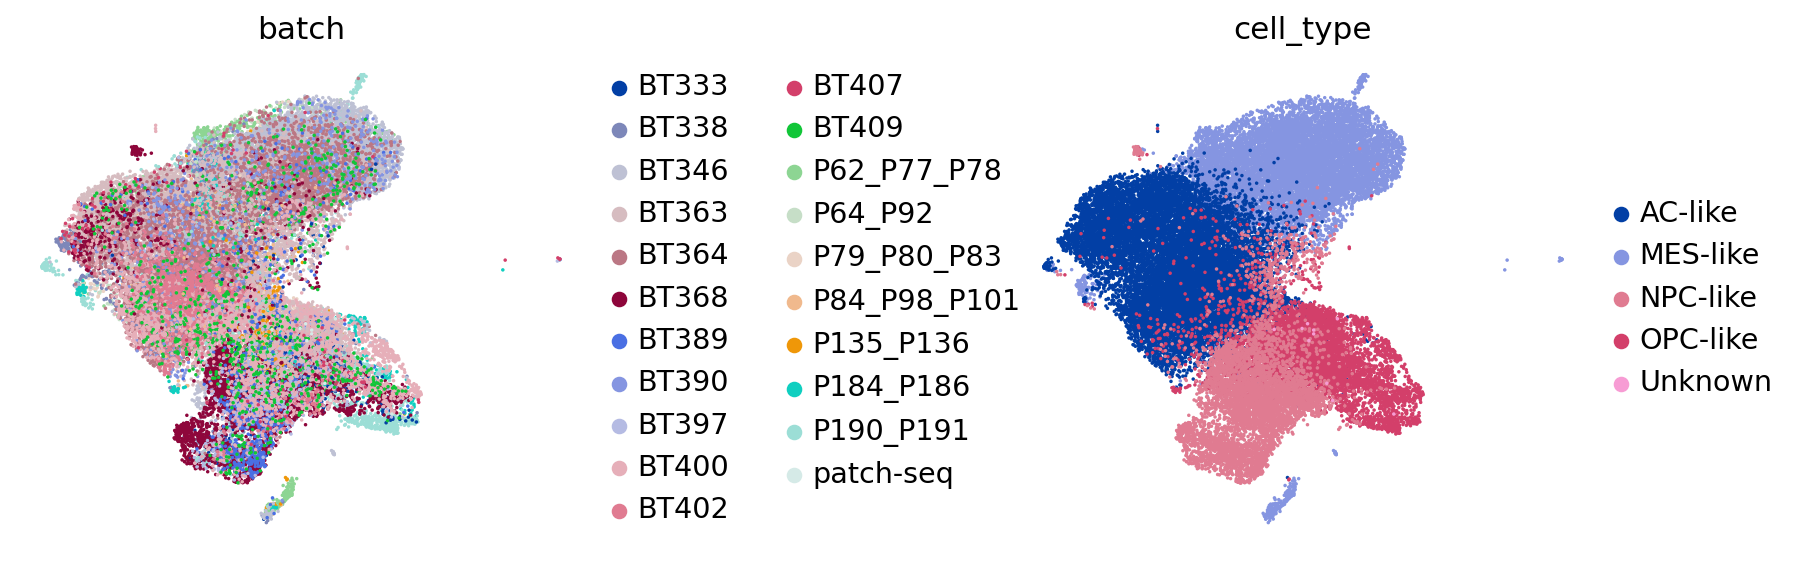

In [78]:
sc.tl.umap(selected,random_state=9)
sc.pl.umap(selected,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           size=10
           )

In [ ]:
'show co-embedding'

In [85]:
umap = pd.DataFrame(selected.obsm['X_umap'],columns=['UMAP_1','UMAP_2'],index=selected.obs.index)
umap['cluster'] = selected.obs['cell_type']

clust_colors = {'TAM1':'#17728C','TAM2':'#C1EDF6','TAM3':'#C5E5BD','TAM4':'#89CFC5','TAM5':'#AA5FAC','Monocytes':'#748EBF','DC cells':'#00C8FB',\
                'Oligodendrocyte':'#AE958C',\
                'B cells':'#ECD157', 'Plasma cells':'#DABB57',\
                'Treg cells':'#fc912a','T-IFI6':'#FF6666',\
                'Cytotoxic CD8T':'#FD9DC6','Exhausted CD8T':'#eedce4',\
                'CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE',\
                'NK cells':'#FF3D73',\
                'MES-like':'#C6008D','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#00CEC4',\
                'neurons':'#4C8266',\
                'Pericyte':'#C83726','VSMCs':'#972826','Endo':'#F51F1A',
                'Unknown':'#8B2323'}

umap['cluster_color'] = umap['cluster'].map(clust_colors)

OPC_cells = umap.loc[umap['cluster'] == 'OPC-like'].index.tolist()
Other_cells = np.intersect1d(umap.loc[umap['cluster'] != 'OPC-like'].index.tolist() , umap.loc[umap['cluster'] != 'Unknown'].index.tolist()    )
EPSC_cells = umap.loc[umap['cluster'] == 'Unknown'].index.tolist()

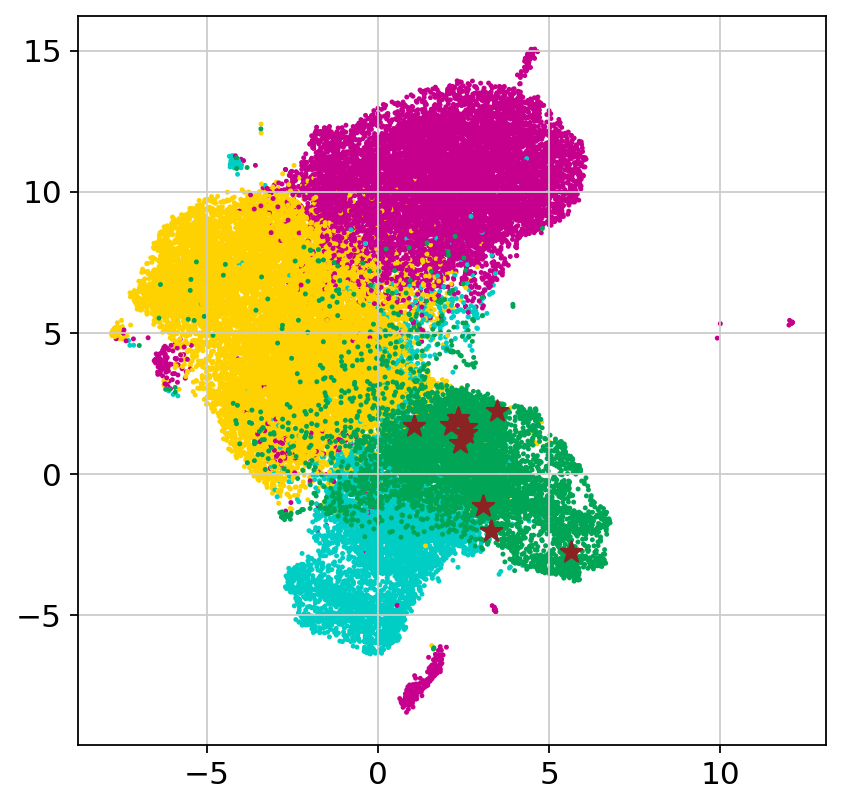

In [86]:
plt.figure(figsize=(6,6))
plt.scatter(x=umap.loc[Other_cells]['UMAP_1'],y=umap.loc[Other_cells]['UMAP_2'],c=umap.loc[Other_cells]['cluster_color'],s=1.5, rasterized=True)
plt.scatter(x=umap.loc[OPC_cells]['UMAP_1'],y=umap.loc[OPC_cells]['UMAP_2'],c=umap.loc[OPC_cells]['cluster_color'],s=1.5, rasterized=True)
plt.scatter(x=umap.loc[EPSC_cells]['UMAP_1'],y=umap.loc[EPSC_cells]['UMAP_2'],s=100,color='#8B2323',marker='*')
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_5/patch_seq_SCANVI_10_cells_new_color.pdf',dpi=500)   
